In [1]:
import os
import numpy as np
import emphases
import pypar

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T


In [3]:
s3_audio = emphases.load.audio('../data/cache/Buckeye/wavs/s03-1.wav')
s11_audio = emphases.load.audio('../data/cache/Buckeye/wavs/s11-1.wav')

#### Get Mel

In [4]:
n_fft = 1024
win_length = 1024
hop_length = 160
n_mels = 80

mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=False,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [5]:
s3_audio.shape

torch.Size([1, 346223])

In [6]:
346223//160

2163

In [7]:
melspec = mel_spectrogram(s3_audio)
melspec.shape

torch.Size([1, 80, 2158])

In [8]:
melspec_s11 = mel_spectrogram(s11_audio)
melspec_s11.shape

torch.Size([1, 80, 2397])

In [9]:
s11_audio.shape[-1]/160.4

2397.2568578553614

#### Get prom and alignment

In [10]:
alignment = pypar.Alignment('../data/cache/Buckeye/alignment/s03-1.json')

word_bounds = alignment.word_bounds(emphases.SAMPLE_RATE, emphases.HOPSIZE)


In [11]:
prominence = emphases.load.load_prominence('../data/cache/Buckeye/annotation/s03-1.prom')

In [12]:
prominence, prominence.shape

(tensor([0.0312, 0.4375, 0.1250, 0.4688, 0.0312, 0.4062, 0.1562, 0.0938, 0.1250,
         0.0000, 0.0938, 0.0000, 0.0312, 0.0000, 0.0000, 0.0938, 0.0938, 0.0000,
         0.3125, 0.0000, 0.1562, 0.4062, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5312, 0.0000, 0.0000, 0.0000, 0.1250, 0.1250, 0.0312, 0.0625, 0.3750,
         0.0312, 0.0312, 0.0000, 0.0312, 0.2188, 0.5312, 0.0000, 0.0938, 0.6250,
         0.0000, 0.0000, 0.0625, 0.0312, 0.1875, 0.3438, 0.1562, 0.0000, 0.0312,
         0.3438, 0.3125, 0.0000, 0.1875, 0.0312, 0.0000, 0.2812, 0.0000, 0.0938,
         0.5938, 0.2812, 0.0312, 0.7188, 0.1875, 0.0938, 0.7812, 0.2812]),
 torch.Size([71]))

### Interpolate

#### Prepare grid

In [13]:
audio_len = s3_audio.shape[-1]
audio_len

346223

In [169]:
def constant(tensor, ratio):
    """Create a grid for constant-ratio time-stretching"""
    return torch.linspace(
        0.,
        tensor.shape[-1] - 1,
#         round((tensor.shape[-1]) / ratio + 1e-4),
        round((tensor.shape[-1]) / (ratio)),
        dtype=torch.float,
        device=tensor.device)

In [170]:
# s3_audio.shape[-1] / 160.4

In [171]:
melspec.shape

torch.Size([1, 80, 2158])

In [172]:
grid = constant(s3_audio, 160.4)
grid, grid[-1]

(tensor([0.0000e+00, 1.6051e+02, 3.2102e+02,  ..., 3.4590e+05, 3.4606e+05,
         3.4622e+05]),
 tensor(346222.))

In [173]:
grid.shape

torch.Size([2158])

In [174]:
def grid_sample(sequence, grid, method='linear'):
    """Perform 1D grid-based sampling"""
    # Require interpolation method to be defined
    if method not in ['linear', 'nearest']:
        raise ValueError(
            f'Interpolation mode {emphases.PPG_INTERP_METHOD} is not defined')

    # Setup grid parameters
    x = grid
    fp = sequence

    # Linear grid interpolation
    if method == 'linear':
        xp = torch.arange(sequence.shape[-1], device=sequence.device)
        i = torch.clip(torch.searchsorted(xp, x, right=True), 1, len(xp) - 1)
        return (
            (fp[..., i - 1] * (xp[i] - x) + fp[..., i] * (x - xp[i - 1])) /
            (xp[i] - xp[i - 1]))

    # Nearest neighbors grid interpolation
    elif method == 'nearest':
        return fp[..., torch.round(x).to(torch.long)]

    else:
        raise ValueError(f'Grid sampling method {method} is not defined')


In [175]:
# interpolated_val = grid_sample(prominence, grid)
# xp = torch.arange(prominence.shape[-1], device=prominence.device)
# i = torch.clip(torch.searchsorted(xp, grid, right=True), 1, len(xp) - 1)

#### Using Numpy

In [176]:
# s3_audio.shape

# 19*160 - 0

# s3_audio.shape[-1] - 2149*160

# 346223//160, 346223/160

# 346080//160, 346080/160

In [177]:
def interpolate_numpy(sequence, grid):
    xp = torch.arange(sequence.shape[-1], device=sequence.device)
    fp = sequence
    return torch.tensor(np.interp(grid, xp, fp), )

In [178]:
wb_prom_pairs = []
audio_len = s3_audio.shape[-1]

if word_bounds[0][0]!=0:
    wb_prom_pairs.append([(0, word_bounds[0][0]), 0])

for idx in range(len(word_bounds)):
    wb_prom_pairs.append([word_bounds[idx], prominence[idx].item()])
    if idx+1<len(word_bounds):
        if word_bounds[idx][-1]!=word_bounds[idx+1][0]:
            start = word_bounds[idx][-1]
            end = word_bounds[idx+1][0]
            wb_prom_pairs.append([(start, end), 0])

In [203]:
prom_extended = []

for wb in wb_prom_pairs:
    start, end = wb[0][0], wb[0][1]
    prom_extended.extend([wb[-1]]*(end-start)*160)
    
if word_bounds[-1][-1]!=audio_len//160:
    pad_len = audio_len - len(prom_extended)
    prom_extended.extend([0]*pad_len)

    
prom_extended = torch.tensor(prom_extended)

In [204]:
len(prom_extended)

346223

In [205]:
audio_len

346223

In [206]:
audio_len - len(prom_extended)

0

### Interpolation Corrected

In [207]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [208]:
grid = constant(s3_audio, 160.4)

In [209]:
interp_prom = interpolate_numpy(prom_extended, grid)

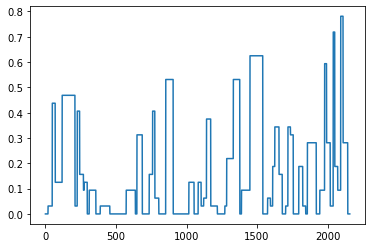

In [210]:
plt.plot(interp_prom.cpu().numpy())